# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Set-up-data" data-toc-modified-id="Set-up-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set up data</a></div><div class="lev1 toc-item"><a href="#Decision-trees" data-toc-modified-id="Decision-trees-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Decision trees</a></div><div class="lev2 toc-item"><a href="#NSRDB-data" data-toc-modified-id="NSRDB-data-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>NSRDB data</a></div><div class="lev3 toc-item"><a href="#Default-tree" data-toc-modified-id="Default-tree-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Default tree</a></div><div class="lev3 toc-item"><a href="#Max-depth-tree" data-toc-modified-id="Max-depth-tree-412"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Max depth tree</a></div><div class="lev2 toc-item"><a href="#Test-on-NSRDB-data" data-toc-modified-id="Test-on-NSRDB-data-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Test on NSRDB data</a></div><div class="lev2 toc-item"><a href="#Test-on-ground-data" data-toc-modified-id="Test-on-ground-data-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test on ground data</a></div><div class="lev2 toc-item"><a href="#First-run" data-toc-modified-id="First-run-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>First run</a></div>

# Introduction

This notebook will explore how closely NSRDB satellite data and RTC ground data agree on irradiance measurements.  We will also look at the agreement between modeled irradiance from NSRDB and that supplied by PVLIB.  Ideally we hope to see that measured irradiances and modeled irradiances are close to one another for both collection methods.  If the NSRDB and ground based RTC data are different, we hope that they are different on a similar scale.

# Load data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools

import pvlib
import utils

import model_free

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

In [2]:
nsrdb_df = pd.read_pickle('./srrl_nsrdb_df.pkl')
ground_df = pd.read_pickle('./srrl_ground_df.pkl')

# Set up data

In [3]:
nsrdb_df.index = nsrdb_df.index.tz_convert('UTC')
ground_df.index = ground_df.index.tz_convert('UTC')

In [4]:
intersection = nsrdb_df.index.intersection(ground_df.index)
EARLIEST_IDX = intersection[0]
LATEST_IDX = intersection[-1]
print('NSRDB date range: {} -> {}'.format(nsrdb_df.index[0], nsrdb_df.index[-1]))
print('Ground date range: {} -> {}'.format(ground_df.index[0], ground_df.index[-1]))
print('Earliest intersection: {}, latest intersection: {}'.format(EARLIEST_IDX, LATEST_IDX))

NSRDB date range: 1998-01-01 00:00:00+00:00 -> 2015-12-31 23:30:00+00:00
Ground date range: 2009-01-01 07:01:00+00:00 -> 2015-01-01 06:59:00+00:00
Earliest intersection: 2009-01-01 07:30:00+00:00, latest intersection: 2015-01-01 06:30:00+00:00


In [5]:
intersection = intersection[intersection >= '01-01-2009']

# Decision trees

In [6]:
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from IPython.display import Image

def fit_model(clf, df, cols):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    scores = model_selection.cross_val_score(estimator=clf, X=X_train, y=y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    print('CV scoring: {} +/ -  {}'.format(np.round(np.mean(scores), 4), np.round(np.std(scores), 4)))
    print('Test score: {}'.format(test_score))
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf

def fit_model_cv_grid(clf, df, cols, param_grid):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    clf_cv = model_selection.GridSearchCV(clf, param_grid)
    clf_cv.fit(X_train, y_train)
    # MAX_DEPTH = clf_cv.best_estimator_.max_depth
    y_pred = clf_cv.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf_cv

## NSRDB data

### Default tree

CV scoring: 0.9034 +/ -  0.0005
Test score: 0.9047383632491633


<IPython.core.display.Javascript object>


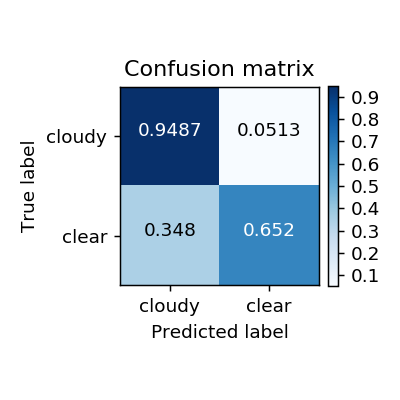

In [7]:
cols = ['GHI', 'abs_diff_ratio stat', 'sky_status']
dt = tree.DecisionTreeClassifier()
dt = fit_model(dt, nsrdb_df, cols)

In [8]:
tree.export_graphviz(dt, out_file='3_b_srrl_default_dt_stat.dot', feature_names=cols[:-1], class_names=['cloudy', 'clear'])
# !dot -Tpng 3_b_srrl_default_dt_stat.dot -o 3_b_srrl_default_dt_stat.png

In [9]:
# Image('3_b_abq_default_dt_stat.png')

Tree is overly complex and difficult to interpret.  Will start by limiting the depth of the tree (using cross val).

### Max depth tree

<IPython.core.display.Javascript object>


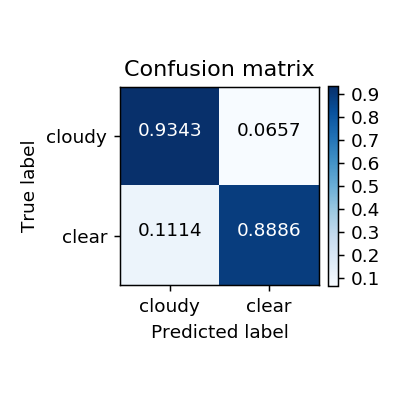

In [10]:
# cols = ['GHI', 'Clearsky GHI stat', 'abs_diff_ratio stat', 'sky_status']
param_grid = {'max_depth': [i for i in range(2, 15)]}
dt = tree.DecisionTreeClassifier()
clf_cv = fit_model_cv_grid(dt, nsrdb_df, cols, param_grid)
dt = clf_cv.best_estimator_

In [11]:
print('Optimal max depth: ', dt.max_depth)
MAX_DEPTH = dt.max_depth

Optimal max depth:  6


In [12]:
tree.export_graphviz(dt, out_file='3_b_srrl_opt_dt_stat.dot', feature_names=cols[:-1], class_names=['cloudy', 'clear'])
!dot -Tpng 3_b_srrl_opt_dt_stat.dot -o 3_b_srrl_opt_dt_stat.png

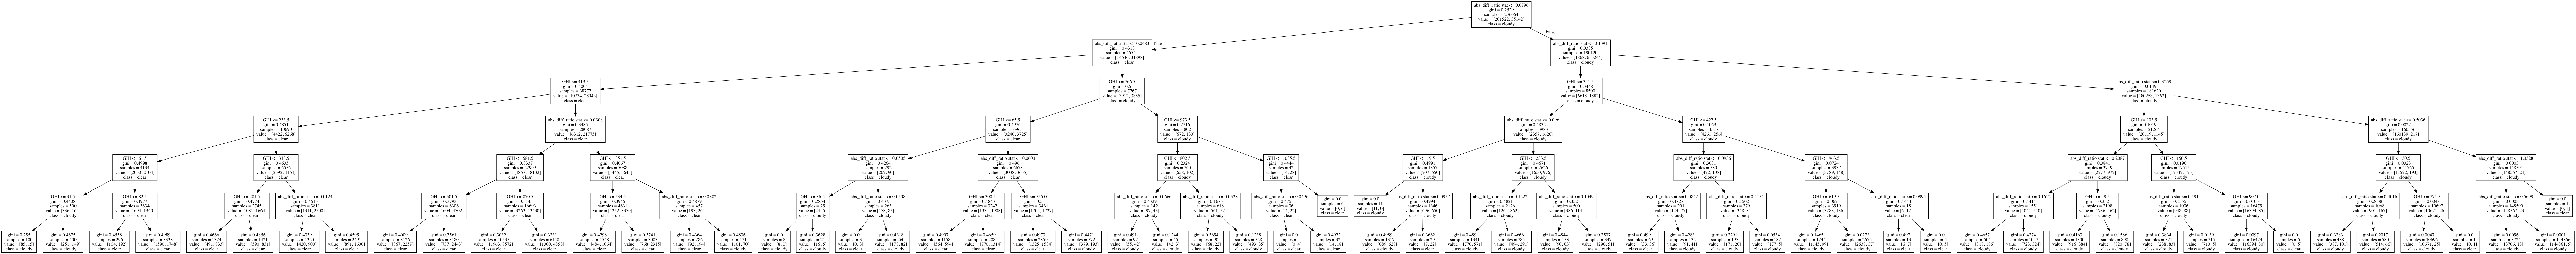

In [13]:
Image('3_b_srrl_opt_dt_stat.png')

<IPython.core.display.Javascript object>


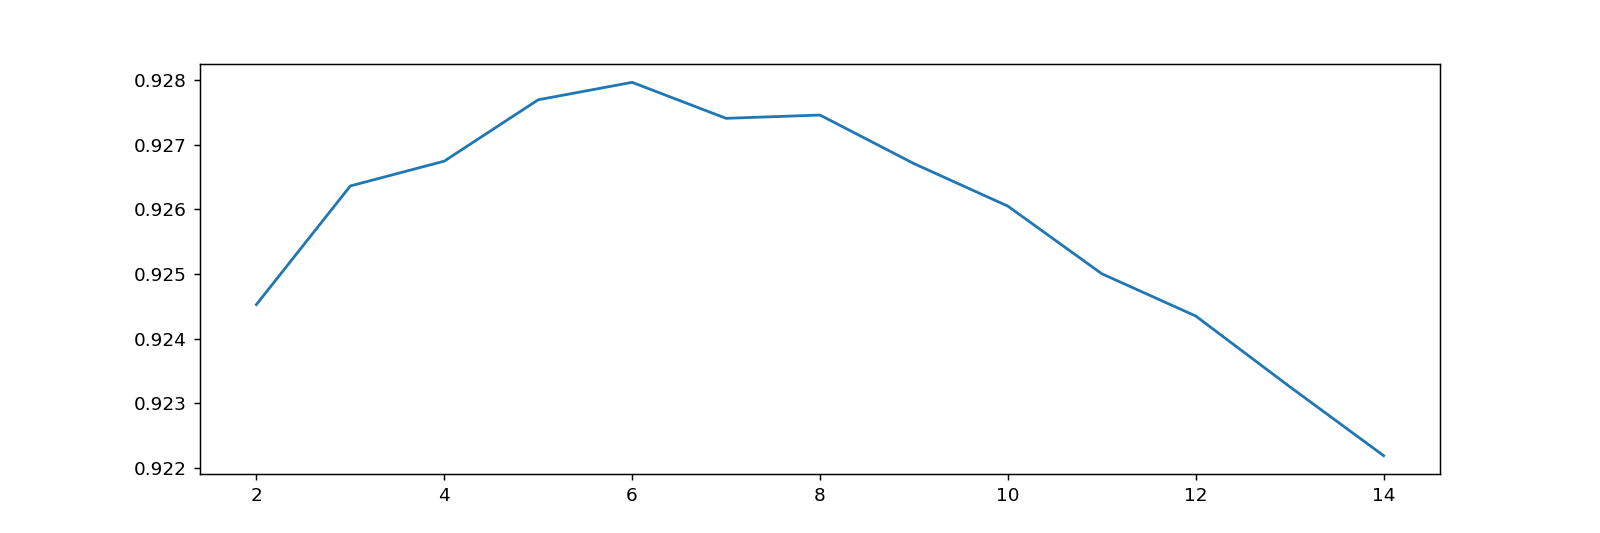

In [14]:
scores = clf_cv.cv_results_['mean_test_score']
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(list(range(2, 15)), scores)

## Test on NSRDB data

In [15]:
train_df = nsrdb_df# [nsrdb_df.index < '01-01-2015']
test_df = nsrdb_df# [nsrdb_df.index >= '01-01-2015']

In [16]:
# cols = ['GHI', 'Clearsky GHI stat', 'abs_diff_ratio stat', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [17]:
predicted_clear = dt.predict(test_df[cols[:-1]])

<IPython.core.display.Javascript object>


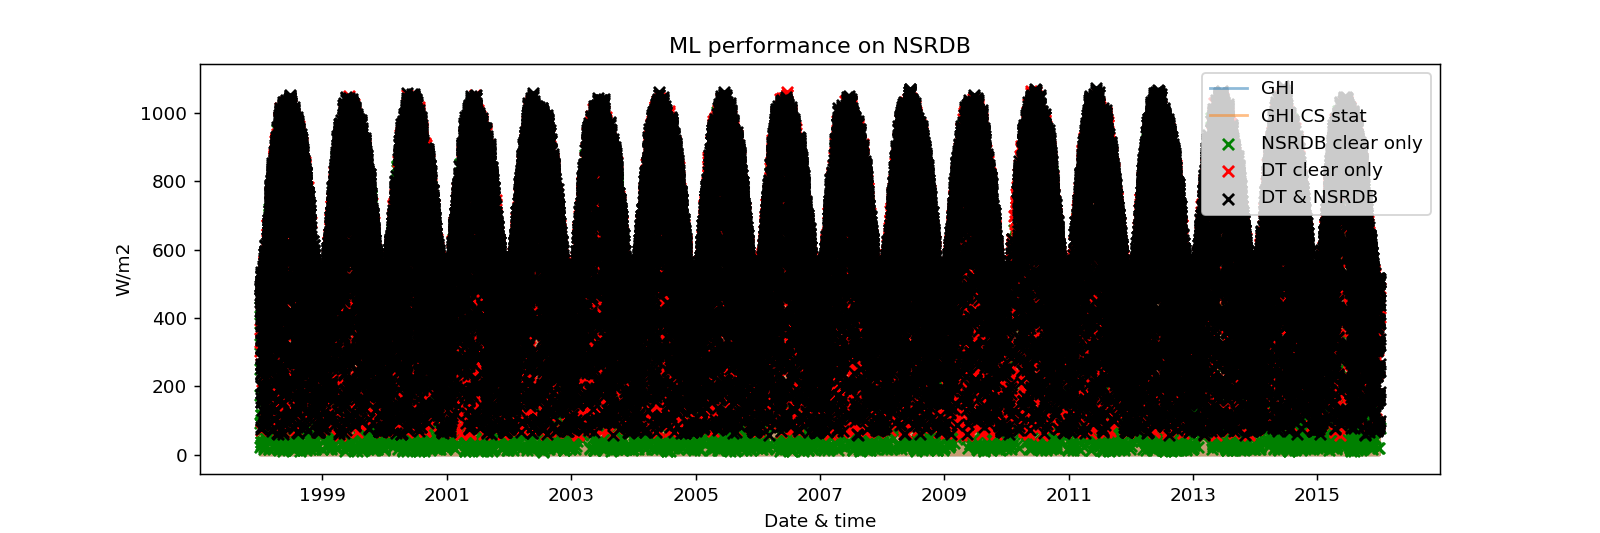

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df[~(predicted_clear) & (test_df['sky_status'] == 1)].index, 
                test_df[~(predicted_clear) & (test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)].index, 
                test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['sky_status'] == 1) & (predicted_clear)].index,
                test_df[(test_df['sky_status'] == 1) & (predicted_clear)]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


DT missing early morning and late evenings again.  In general though, the performance is very good.  There are limited cases where the DT detection looks incorrect. 

## Test on ground data

## First run

In [19]:
train_df = nsrdb_df
test_df = ground_df# [ground_df.index >= '01-01-2015']

In [20]:
# cols = ['GHI', 'Clearsky GHI stat', 'abs_diff_ratio stat', 'sky_status']
# cols = ['abs_diff_ratio stat', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [21]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

In [22]:
train_df = train_df.loc[intersection]
test_df = test_df.loc[intersection]

<IPython.core.display.Javascript object>


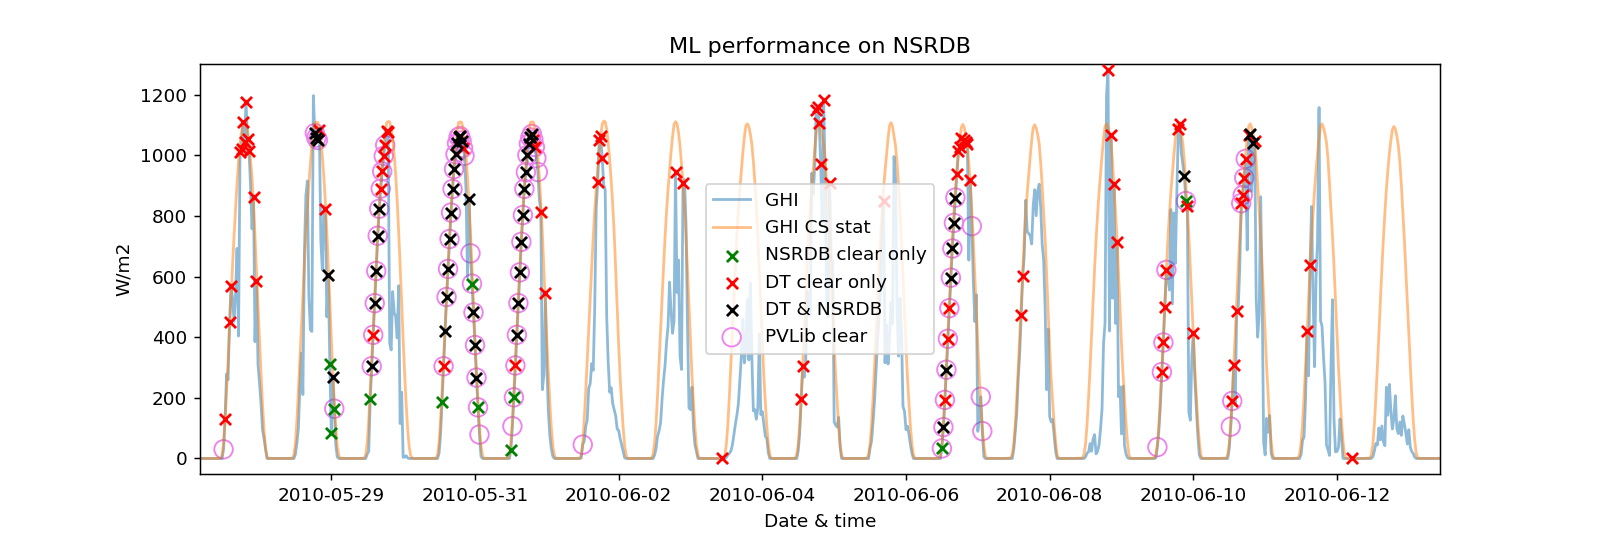

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

p6 = ax.scatter(test_df[test_df['sky_status'] == 1].index,
                test_df[test_df['sky_status'] == 1]['GHI'],
                marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')
